<a href="https://colab.research.google.com/github/Stephanie9606/Multimodal_Deep_Learning/blob/main/binary_vgg_memes_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten

In [ ]:
# Set up the device for GPU usage
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# connect to google drive for files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pre-processing

In [ ]:
train = pd.read_pickle("/content/drive/MyDrive/DATA-793 Pinyu Chen/train_allfeats_09052022.pkl")

In [ ]:
test = pd.read_pickle("/content/drive/MyDrive/DATA-793 Pinyu Chen/test_allfeats_09052022.pkl")

In [ ]:
# train.iloc[1]

In [ ]:
Text_train = train.iloc[:, 4:9]
Text_test = test.iloc[:, 4:9]

In [ ]:
Text_train['ImagePath'] = '/content/drive/MyDrive/DATA-793 Pinyu Chen/Train_Images_2016/' + Text_train['new_img_id'] + '.jpg'
Text_test['ImagePath'] = '/content/drive/MyDrive/DATA-793 Pinyu Chen/Test_Images_2016/' + Text_test['new_img_id'] + '.jpg'

In [ ]:
Text_train.head(3)

,tweet_text,label,event,new_img_id,clean_tweet,ImagePath
0,Don't need feds to solve the #bostonbombing wh...,fake,boston,boston_fake_03,"[don, need, feds, solve, bostonbombing, 4chan]",/content/drive/MyDrive/DATA-793 Pinyu Chen/Tra...
1,PIC: Comparison of #Boston suspect Sunil Tripa...,fake,boston,boston_fake_23,"[pic, comparison, boston, suspect, sunil, trip...",/content/drive/MyDrive/DATA-793 Pinyu Chen/Tra...
2,I'm not completely convinced that it's this Su...,fake,boston,boston_fake_34,"[completely, convinced, sunil, tripathi, fellow]",/content/drive/MyDrive/DATA-793 Pinyu Chen/Tra...


In [ ]:
Text_train['tweet_text'] = Text_train['tweet_text'].astype(pd.StringDtype())
Text_train['label'] = Text_train['label'].astype(pd.StringDtype())
Text_train['event'] = Text_train['event'].astype(pd.StringDtype())
Text_train['new_img_id'] = Text_train['new_img_id'].astype(pd.StringDtype())
Text_train['clean_tweet'] = Text_train['clean_tweet'].astype(pd.StringDtype())
Text_train['ImagePath'] = Text_train['ImagePath'].astype(pd.StringDtype())

Text_test['tweet_text'] = Text_test['tweet_text'].astype(pd.StringDtype())
Text_test['label'] = Text_test['label'].astype(pd.StringDtype())
Text_test['event'] = Text_test['event'].astype(pd.StringDtype())
Text_test['new_img_id'] = Text_test['new_img_id'].astype(pd.StringDtype())
Text_test['clean_tweet'] = Text_test['clean_tweet'].astype(pd.StringDtype())
Text_test['ImagePath'] = Text_test['ImagePath'].astype(pd.StringDtype())

In [ ]:
# Only two label for Binary Classification

In [ ]:
Text_train.head(3)

,tweet_text,label,event,new_img_id,clean_tweet,ImagePath
0,Don't need feds to solve the #bostonbombing wh...,fake,boston,boston_fake_03,"['don', 'need', 'feds', 'solve', 'bostonbombin...",/content/drive/MyDrive/DATA-793 Pinyu Chen/Tra...
1,PIC: Comparison of #Boston suspect Sunil Tripa...,fake,boston,boston_fake_23,"['pic', 'comparison', 'boston', 'suspect', 'su...",/content/drive/MyDrive/DATA-793 Pinyu Chen/Tra...
2,I'm not completely convinced that it's this Su...,fake,boston,boston_fake_34,"['completely', 'convinced', 'sunil', 'tripathi...",/content/drive/MyDrive/DATA-793 Pinyu Chen/Tra...


In [ ]:
print(Text_train.shape)
print(Text_test.shape)

(9142, 6)
(796, 6)


In [ ]:
print(Text_train['label'].value_counts())
print(Text_test['label'].value_counts())

fake    5129
real    4013
Name: label, dtype: Int64
fake    467
real    329
Name: label, dtype: Int64


# Example of image

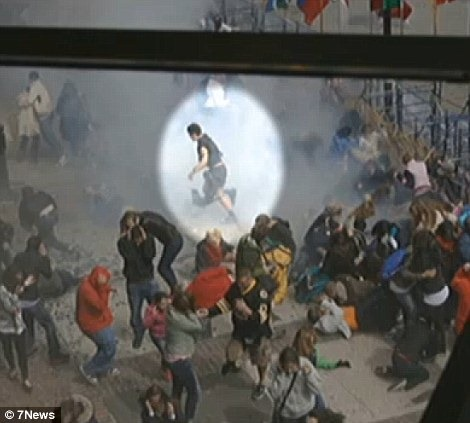

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/DATA-793 Pinyu Chen/Train_Images_2016/boston_fake_02.jpg')
cv2_imshow(img)

# Data augmentation

In [ ]:
 # Loading training data
batch_size = 32
img_height = 224
img_width = 224
train_datagen = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input, rescale=1./255.,validation_split=0.25)
train_generator = train_datagen.flow_from_dataframe(dataframe=Text_train, 
                                                    directory=None, 
                                                    x_col="ImagePath", 
                                                    y_col="label", 
                                                    subset="training", 
                                                    seed = 55, 
                                                    class_mode="binary", 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size)

valid_generator = train_datagen.flow_from_dataframe(dataframe=Text_train, 
                                                    directory=None, 
                                                    x_col="ImagePath", 
                                                    y_col="label", 
                                                    subset="validation", 
                                                    seed = 55, 
                                                    class_mode="binary", 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batch_size)

print(f"Class labels: {train_generator.class_indices}")

Found 6857 validated image filenames belonging to 2 classes.
Found 2285 validated image filenames belonging to 2 classes.
Class labels: {'fake': 0, 'real': 1}


# Load Pre-trained Model-base VGG-16 [Model 1]

In [ ]:
tf.random.set_seed(45)

# Load original model with pretrained weights from imagenet
base_model = applications.VGG16(weights="imagenet")

# Freeze base model
base_model.trainable = False

# Create new model on top
img_height = 224
img_width = 224
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
outputs = Dense(1, activation="sigmoid")(x) # output probabilities for both classes
model1 = Model(inputs, outputs)
model1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_12 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 138,358,545
Trainable params: 1,001
Non-trainable params: 138,357,544
_________________________________________________________________


# Load Pre-trained Model-base VGG-16 with relu activation (Batch Normalization) and dropout [Model 2]

In [ ]:
# Try deeper model on top
img_height = 224
img_width = 224
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)

hidden1 = Flatten(name="flatten")(x)
hidden2 = Dense(512, activation="relu")(hidden1)
hidden3 = Dropout(0.5)(hidden2)

outputs = Dense(1, activation="sigmoid")(hidden3) # we want to output probabilities for both classes
model2 = Model(inputs, outputs)
model2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               512512    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 513       
                                                                 
Total params: 138,870,569
Trainable params: 513,025
Non-tra

# Load Pre-trained Model-base VGG-16 with relu activation (Batch Normalization) and dropout [Model 3]

In [ ]:
# Try deeper model on top
img_height = 224
img_width = 224
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)

hidden1 = Flatten(name="flatten")(x)
hidden2 = keras.layers.BatchNormalization()(hidden1)
hidden3 = Dense(512, activation="relu")(hidden2)
hidden4 = Dropout(0.5)(hidden3)

outputs = Dense(1, activation="sigmoid")(hidden4) # we want to output probabilities for both classes
model3 = Model(inputs, outputs)
model3.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 512)               512512    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                           

# Load Pre-trained Model-base VGG-16 with SELU activation (lecun_normal) and alphadropout [Model 4]

In [ ]:
# Try deeper model on top
img_height = 224
img_width = 224
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)

hidden = Flatten(name="flatten")(x)
hidden = Dense(512, activation="selu", kernel_initializer="lecun_normal")(hidden)
hidden = keras.layers.AlphaDropout(0.5)(hidden)
# hidden = Dense(256, activation="selu", kernel_initializer="lecun_normal")(hidden)
# hidden = keras.layers.AlphaDropout(0.7)(hidden)
# hidden = Dense(128, activation="selu", kernel_initializer="lecun_normal")(hidden)
# hidden = keras.layers.AlphaDropout(0.7)(hidden)

outputs = Dense(1, activation="sigmoid")(hidden) # we want to output probabilities for both classes
model4 = Model(inputs, outputs)
model4.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense_23 (Dense)            (None, 512)               512512    
                                                                 
 alpha_dropout_7 (AlphaDropo  (None, 512)              0         
 ut)                                                             
                                                                 
 dense_24 (Dense)            (None, 1)                 513       
                                                          

# Early stopping and model saving

In [ ]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystopping1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# Save and Load model
checkpoint_filepath = '/content/drive/MyDrive/DATA-793 Pinyu Chen/model_tweet_image1.h5'
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystopping2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Save and Load model
checkpoint_filepath = '/content/drive/MyDrive/DATA-793 Pinyu Chen/model_tweet_image2.h5'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystopping3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Save and Load model
checkpoint_filepath = '/content/drive/MyDrive/DATA-793 Pinyu Chen/model_tweet_image3.h5'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
earlystopping4 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Save and Load model
checkpoint_filepath = '/content/drive/MyDrive/DATA-793 Pinyu Chen/model_tweet_image4.h5'
model_checkpoint_callback4 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Exponential Scheduling

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 12.5)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=12.5)

In [ ]:
# callbacks=[lr_scheduler]
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Performance Scheduling

In [ ]:
# lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# Nadam

In [ ]:
# optimizer and metric
# keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model4.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 10

# Adam

In [ ]:
#import mlflow.tensorflow
# from tensorflow.keras.optimizers import Adam

# optimizer and metric
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
n_epochs = 10

# Training model 1

In [ ]:
# Train the model 
# step_size_train=train_generator.n//train_generator.batch_size
# step_size_valid=valid_generator.n//valid_generator.batch_size

train_history1 = model1.fit(train_generator,
                            # steps_per_epoch=step_size_train,
                            validation_data=valid_generator,
                            # validation_steps=step_size_valid,
                            epochs=n_epochs,
                            callbacks=[model_checkpoint_callback1, earlystopping1, lr_scheduler],
                            verbose=2 # show: epoch 1/10
)

Epoch 1/10
215/215 - 116s - loss: 0.6690 - accuracy: 0.5879 - val_loss: 0.8243 - val_accuracy: 0.0118 - lr: 0.0100 - 116s/epoch - 540ms/step
Epoch 2/10
215/215 - 109s - loss: 0.6500 - accuracy: 0.6078 - val_loss: 0.7597 - val_accuracy: 0.2595 - lr: 0.0083 - 109s/epoch - 508ms/step
Epoch 3/10
215/215 - 104s - loss: 0.6378 - accuracy: 0.6227 - val_loss: 0.7954 - val_accuracy: 0.2569 - lr: 0.0069 - 104s/epoch - 484ms/step
Epoch 4/10
215/215 - 107s - loss: 0.6283 - accuracy: 0.6617 - val_loss: 0.7683 - val_accuracy: 0.2722 - lr: 0.0058 - 107s/epoch - 498ms/step
Epoch 5/10
215/215 - 108s - loss: 0.6213 - accuracy: 0.6703 - val_loss: 0.7548 - val_accuracy: 0.3374 - lr: 0.0048 - 108s/epoch - 502ms/step
Epoch 6/10
215/215 - 105s - loss: 0.6159 - accuracy: 0.6786 - val_loss: 0.7679 - val_accuracy: 0.3212 - lr: 0.0040 - 105s/epoch - 487ms/step
Epoch 7/10
215/215 - 103s - loss: 0.6118 - accuracy: 0.6838 - val_loss: 0.7639 - val_accuracy: 0.3352 - lr: 0.0033 - 103s/epoch - 477ms/step
Epoch 8/10
21

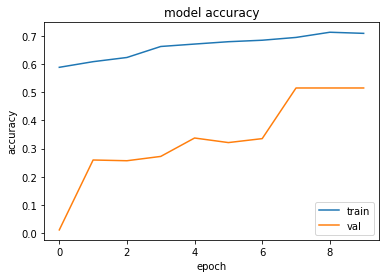

In [ ]:
import matplotlib.pyplot as plt
# plot accuracy
plt.plot(train_history1.history['accuracy'])
plt.plot(train_history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

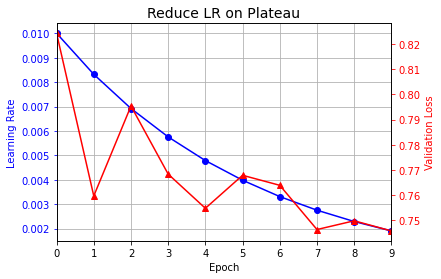

In [ ]:
plt.plot(train_history1.epoch, train_history1.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(train_history1.epoch, train_history1.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# Training model 2

In [ ]:
# Train the model 
# step_size_train=train_generator.n//train_generator.batch_size
# step_size_valid=valid_generator.n//valid_generator.batch_size

train_history2 = model2.fit(train_generator,
                            # steps_per_epoch=step_size_train,
                            validation_data=valid_generator,
                            # validation_steps=step_size_valid,
                            epochs=n_epochs,
                            callbacks=[model_checkpoint_callback2, earlystopping2, lr_scheduler],
                            verbose=2 # show: epoch 1/10
)

Epoch 1/10
215/215 - 126s - loss: 0.6065 - accuracy: 0.6706 - val_loss: 0.4910 - val_accuracy: 0.7160 - lr: 0.0100 - 126s/epoch - 586ms/step
Epoch 2/10
215/215 - 107s - loss: 0.4603 - accuracy: 0.7915 - val_loss: 0.7095 - val_accuracy: 0.6389 - lr: 0.0083 - 107s/epoch - 498ms/step
Epoch 3/10
215/215 - 108s - loss: 0.3868 - accuracy: 0.8371 - val_loss: 0.4913 - val_accuracy: 0.7939 - lr: 0.0069 - 108s/epoch - 502ms/step
Epoch 4/10
215/215 - 109s - loss: 0.3452 - accuracy: 0.8655 - val_loss: 0.3042 - val_accuracy: 0.8770 - lr: 0.0058 - 109s/epoch - 509ms/step
Epoch 5/10
215/215 - 108s - loss: 0.3164 - accuracy: 0.8756 - val_loss: 0.2715 - val_accuracy: 0.8858 - lr: 0.0048 - 108s/epoch - 502ms/step
Epoch 6/10
215/215 - 104s - loss: 0.2912 - accuracy: 0.8897 - val_loss: 0.3502 - val_accuracy: 0.8696 - lr: 0.0040 - 104s/epoch - 485ms/step
Epoch 7/10
215/215 - 102s - loss: 0.2751 - accuracy: 0.8978 - val_loss: 0.4626 - val_accuracy: 0.8481 - lr: 0.0033 - 102s/epoch - 474ms/step
Epoch 8/10
21

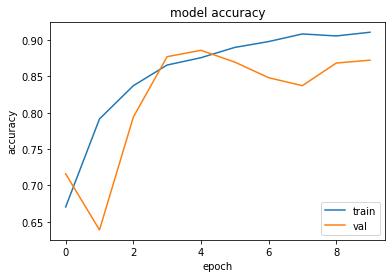

In [ ]:
# plot accuracy
plt.plot(train_history2.history['accuracy'])
plt.plot(train_history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

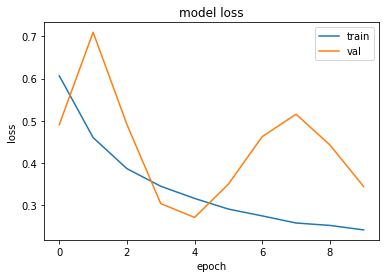

In [ ]:
# plot loss
plt.plot(train_history2.history['loss'])
plt.plot(train_history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

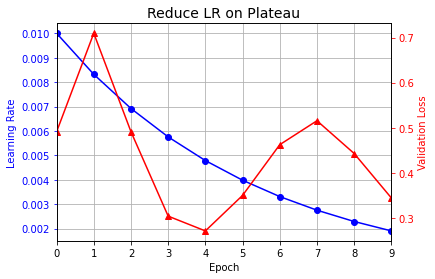

In [ ]:
plt.plot(train_history2.epoch, train_history2.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(train_history2.epoch, train_history2.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# Training model 3

In [ ]:
# Train the model 
# step_size_train=train_generator.n//train_generator.batch_size
# step_size_valid=valid_generator.n//valid_generator.batch_size

train_history3 = model3.fit(train_generator,
                            # steps_per_epoch=step_size_train,
                            validation_data=valid_generator,
                            # validation_steps=step_size_valid,
                            epochs=n_epochs,
                            callbacks=[model_checkpoint_callback3, earlystopping3, lr_scheduler],
                            verbose=2 # show: epoch 1/10
)

Epoch 1/10
215/215 - 121s - loss: 0.3346 - accuracy: 0.8486 - val_loss: 0.4704 - val_accuracy: 0.9996 - lr: 0.0100 - 121s/epoch - 562ms/step
Epoch 2/10
215/215 - 106s - loss: 0.1666 - accuracy: 0.9370 - val_loss: 0.2556 - val_accuracy: 1.0000 - lr: 0.0083 - 106s/epoch - 494ms/step
Epoch 3/10
215/215 - 105s - loss: 0.1252 - accuracy: 0.9565 - val_loss: 0.0962 - val_accuracy: 0.9781 - lr: 0.0069 - 105s/epoch - 486ms/step
Epoch 4/10
215/215 - 102s - loss: 0.0971 - accuracy: 0.9659 - val_loss: 0.5343 - val_accuracy: 0.8691 - lr: 0.0058 - 102s/epoch - 475ms/step
Epoch 5/10
215/215 - 103s - loss: 0.0816 - accuracy: 0.9748 - val_loss: 0.2623 - val_accuracy: 0.9199 - lr: 0.0048 - 103s/epoch - 481ms/step
Epoch 6/10
215/215 - 102s - loss: 0.0623 - accuracy: 0.9810 - val_loss: 0.3203 - val_accuracy: 0.8963 - lr: 0.0040 - 102s/epoch - 473ms/step
Epoch 7/10
215/215 - 102s - loss: 0.0521 - accuracy: 0.9832 - val_loss: 0.1909 - val_accuracy: 0.9239 - lr: 0.0033 - 102s/epoch - 475ms/step
Epoch 8/10
21

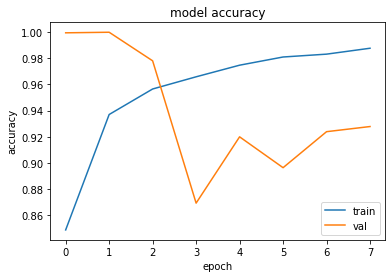

In [ ]:
# plot accuracy
plt.plot(train_history3.history['accuracy'])
plt.plot(train_history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

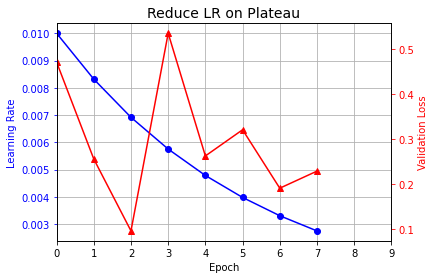

In [ ]:
plt.plot(train_history3.epoch, train_history3.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(train_history3.epoch, train_history3.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# Training model 4

In [ ]:
# Train the model 
# step_size_train=train_generator.n//train_generator.batch_size
# step_size_valid=valid_generator.n//valid_generator.batch_size

train_history4 = model4.fit(train_generator,
                            # steps_per_epoch=step_size_train,
                            validation_data=valid_generator,
                            # validation_steps=step_size_valid,
                            epochs=n_epochs,
                            callbacks=[model_checkpoint_callback4, earlystopping4, lr_scheduler],
                            verbose=2 # show: epoch 1/10
)

Epoch 1/10
215/215 - 112s - loss: 0.7335 - accuracy: 0.5731 - val_loss: 0.9262 - val_accuracy: 0.5098 - lr: 0.0100 - 112s/epoch - 520ms/step
Epoch 2/10
215/215 - 104s - loss: 0.6489 - accuracy: 0.6453 - val_loss: 1.5672 - val_accuracy: 0.2503 - lr: 0.0083 - 104s/epoch - 482ms/step
Epoch 3/10
215/215 - 107s - loss: 0.6238 - accuracy: 0.6730 - val_loss: 0.6804 - val_accuracy: 0.6683 - lr: 0.0069 - 107s/epoch - 499ms/step
Epoch 4/10
215/215 - 108s - loss: 0.5913 - accuracy: 0.6898 - val_loss: 0.5283 - val_accuracy: 0.7125 - lr: 0.0058 - 108s/epoch - 502ms/step
Epoch 5/10
215/215 - 103s - loss: 0.5647 - accuracy: 0.7130 - val_loss: 0.5468 - val_accuracy: 0.6775 - lr: 0.0048 - 103s/epoch - 481ms/step
Epoch 6/10
215/215 - 107s - loss: 0.5487 - accuracy: 0.7238 - val_loss: 0.4708 - val_accuracy: 0.7707 - lr: 0.0040 - 107s/epoch - 497ms/step
Epoch 7/10
215/215 - 105s - loss: 0.5297 - accuracy: 0.7334 - val_loss: 0.4792 - val_accuracy: 0.7707 - lr: 0.0033 - 105s/epoch - 487ms/step
Epoch 8/10
21

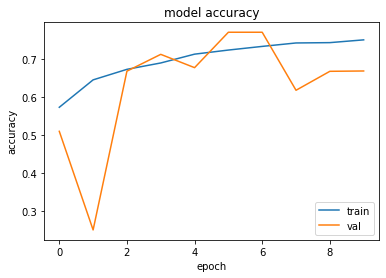

In [ ]:
# plot accuracy
plt.plot(train_history4.history['accuracy'])
plt.plot(train_history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

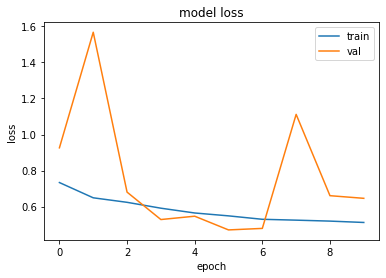

In [ ]:
# plot loss
plt.plot(train_history4.history['loss'])
plt.plot(train_history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

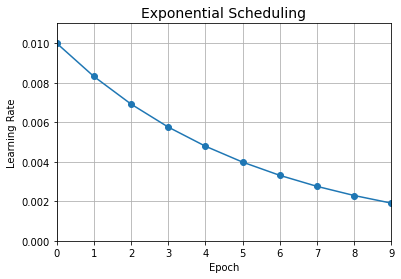

In [ ]:
plt.plot(train_history4.epoch, train_history4.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

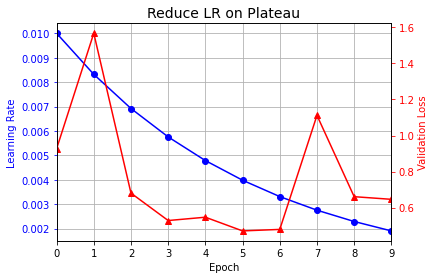

In [ ]:
plt.plot(train_history4.epoch, train_history4.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(train_history4.epoch, train_history4.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# Evaluate model on test set

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input, rescale=1./255.)

In [ ]:
# Evaluate
batch_size = 32

test_generator = train_datagen.flow_from_dataframe(dataframe=Text_test, 
                                                   directory=None, 
                                                   x_col="ImagePath", 
                                                   y_col="label",
                                                   seed = 55, 
                                                   class_mode="binary", 
                                                   target_size=(img_height, img_width),
                                                   shuffle=False,
                                                   batch_size=batch_size)

step_size_test = test_generator.n//test_generator.batch_size

eval_results = model1.evaluate(test_generator, steps=step_size_test)
print(f"Loss: {eval_results[0]}. Accuracy: {eval_results[1]}")

In [ ]:
# Evaluate

# eval_results = model1.evaluate(test_generator, steps=step_size_test)
# print(f"Loss: {eval_results[0]}. Accuracy: {eval_results[1]}")

# eval_results = model2.evaluate(test_generator, steps=step_size_test)
# print(f"Loss: {eval_results[0]}. Accuracy: {eval_results[1]}")

# eval_results = model3.evaluate(test_generator, steps=step_size_test)
# print(f"Loss: {eval_results[0]}. Accuracy: {eval_results[1]}")

eval_results = model4.evaluate(test_generator, steps=step_size_test)
print(f"Loss: {eval_results[0]}. Accuracy: {eval_results[1]}")

24/24 [==============================] - 7s 272ms/step - loss: 0.9930 - accuracy: 0.6341
Loss: 0.9930024147033691. Accuracy: 0.6341145634651184


In [ ]:
# new_model = tf.keras.models.load_model('/content/drive/MyDrive/DATA-793 Pinyu Chen/model_tweet_image.h5')

# Load model with weight

In [ ]:
# from tensorflow.keras.models import Model
# import tensorflow as tf

In [ ]:
# from tensorflow.keras import applications

# tf.random.set_seed(45)

# # Load original model with pretrained weights from imagenet
# base_model = applications.VGG16(weights="imagenet")

# # Freeze base model
# base_model.trainable = False

# # Try deeper model on top
# img_height = 224
# img_width = 224
# inputs = Input(shape=(img_height, img_width, 3))
# x = base_model(inputs, training=False)

# hidden = Flatten(name="flatten")(x)
# hidden = Dense(512, activation="selu", kernel_initializer="lecun_normal")(hidden)
# hidden = keras.layers.AlphaDropout(0.7)(hidden)
# hidden = Dense(256, activation="selu", kernel_initializer="lecun_normal")(hidden)
# hidden = keras.layers.AlphaDropout(0.7)(hidden)
# hidden = Dense(128, activation="selu", kernel_initializer="lecun_normal")(hidden)
# hidden = keras.layers.AlphaDropout(0.7)(hidden)

# outputs = Dense(1, activation="sigmoid")(hidden) # we want to output probabilities for both classes
# model4 = Model(inputs, outputs)
# model4.summary()

In [ ]:
# The model weights (that are considered the best) are loaded into the
# model.
# model4.load_weights('/content/drive/MyDrive/DATA-793 Pinyu Chen/model_tweet_image4.h5')

In [ ]:
# Check its architecture
# model4.summary()